In [47]:
import pandas as pd
# from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
# from PIL import Image
import numpy as np
# from numpy.random import permutation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34, vgg16
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import pickle
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

class FeaturesDataset(Dataset):

    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst

    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])

    def __len__(self):
        return len(self.labellst)

def fit(epoch, model, data_loader, optimizer, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)

        running_loss += F.cross_entropy(output,target,size_average=False).data.item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy


In [5]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [7]:
folds_csv = pd.read_csv('./datasets/Folds.csv')

In [10]:
benign_images = getListOfFiles('./datasets/Dataset/benign')
malignant_images = getListOfFiles('./datasets/Dataset/malignant')
print('Number of benign images:', len(benign_images))
print('Number of malignant images:', len(malignant_images))
print('Total number of images:', len(benign_images) + len(malignant_images))

Number of benign images: 2480
Number of malignant images: 5429
Total number of images: 7909


In [11]:
benign_df = pd.DataFrame(benign_images, columns=['image_path'])
benign_df['label'] = 0
benign_upsampled = resample(benign_df, replace=True, n_samples=len(malignant_images), random_state=42)
malignant_df = pd.DataFrame(malignant_images, columns=['image_path'])
malignant_df['label'] = 1

In [12]:
all_images = pd.concat([benign_upsampled, malignant_df], axis=0)
all_images = all_images.sample(frac=1).reset_index(drop=True)
all_images

,image_path,label
0,./datasets/Dataset/benign/SOB_B_TA-14-16184-20...,0
1,./datasets/Dataset/malignant/SOB_M_DC-14-16716...,1
2,./datasets/Dataset/malignant/SOB_M_PC-14-12465...,1
3,./datasets/Dataset/benign/SOB_B_PT-14-21998AB-...,0
4,./datasets/Dataset/benign/SOB_B_F-14-23060CD-2...,0
...,...,...
10853,./datasets/Dataset/benign/SOB_B_A-14-22549CD-2...,0
10854,./datasets/Dataset/benign/SOB_B_A-14-29960CD-1...,0
10855,./datasets/Dataset/malignant/SOB_M_LC-14-15570...,1
10856,./datasets/Dataset/malignant/SOB_M_DC-14-2980-...,1


In [13]:
train_val_data, test_data = train_test_split(all_images,test_size=0.2,random_state=42)
train_data, valid_data = train_test_split(train_val_data,test_size=0.2,random_state=42)


In [14]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

train_data

(6948, 2)
(2172, 2)
(1738, 2)


,image_path,label
1571,./datasets/Dataset/benign/SOB_B_A-14-22549AB-2...,0
8171,./datasets/Dataset/malignant/SOB_M_MC-14-13413...,1
7491,./datasets/Dataset/benign/SOB_B_PT-14-22704-20...,0
9802,./datasets/Dataset/benign/SOB_B_F-14-21998EF-2...,0
10103,./datasets/Dataset/malignant/SOB_M_DC-14-10926...,1
...,...,...
10563,./datasets/Dataset/malignant/SOB_M_MC-14-19979...,1
9290,./datasets/Dataset/malignant/SOB_M_DC-14-2980-...,1
2005,./datasets/Dataset/malignant/SOB_M_DC-14-18650...,1
6271,./datasets/Dataset/malignant/SOB_M_LC-14-16196...,1


In [15]:
print(test_data['label'].value_counts())

label
1    1089
0    1083
Name: count, dtype: int64


In [16]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [17]:
train_dataset = []
for i in range(len(train_data)):
    img = Image.open(train_data['image_path'].values[i])
    img = data_transform(img)
    train_dataset.append((img, train_data['label'].values[i]))  


In [18]:
valid_dataset = []
for i in range(len(valid_data)):
    img = Image.open(valid_data['image_path'].values[i])
    img = data_transform(img)
    valid_dataset.append((img, valid_data['label'].values[i]))

In [19]:
test_dataset = []
for i in range(len(test_data)):
    img = Image.open(test_data['image_path'].values[i])
    img = data_transform(img)
    test_dataset.append((img, test_data['label'].values[i]))

In [20]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

6948
1738
2172


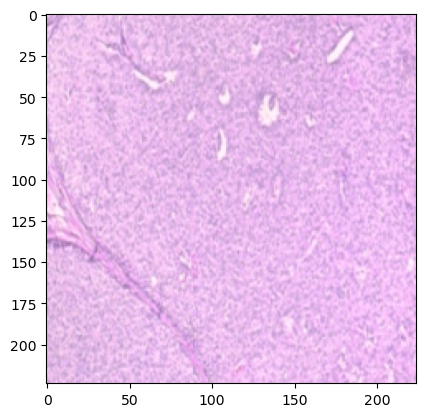

In [21]:
imshow(train_dataset[1][0])


In [22]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=False,num_workers=2)
val_loader = DataLoader(valid_dataset,batch_size=64,shuffle=False,num_workers=2)
test_data_loader = DataLoader(test_dataset,batch_size=64,shuffle=False,num_workers=2)
classes = 2

In [ ]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

In [24]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

In [25]:
#for training data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trn_labels = [] #stores the labels or the train data

trn_features = [] #stores the pre convoluted features of the train data

#iterate through the train data and store the calculated features and the labels
for d, la in train_loader:
  o = m(Variable(d.to(device)))  #a PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph
  o = o.view(o.size(0), -1)
  trn_labels.extend(la)
  trn_features.extend(o.to(device).data)

#for validation data

#iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d, la in val_loader:
  o = m(Variable(d.to(device)))
  o = o.view(o.size(0), -1)
  val_labels.extend(la)
  val_features.extend(o.to(device).data)

#for test data
test_labels = []
test_features = []
for d, la in test_data_loader:
  o = m(Variable(d.to(device)))
  o = o.view(o.size(0), -1)
  test_labels.extend(la)
  test_features.extend(o.to(device).data)

In [35]:
#creating the dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features, trn_labels)
val_feat_dset = FeaturesDataset(val_features, val_labels)
tst_feat_dset = FeaturesDataset(test_features, test_labels)

#creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset, batch_size=64, shuffle=True)
val_feat_loader = DataLoader(val_feat_dset, batch_size=64)
tst_feat_loader = DataLoader(tst_feat_dset, batch_size=64)

In [36]:
class FullyConnectedModel(nn.Module):
  def __init__(self, in_size, out_size):
    super().__init__()
    self.fc = nn.Linear(in_size, out_size)

  def forward(self, inp):
    out = self.fc(inp)
    return out

In [37]:
fc_in_size = 512
classes = 2
fc = FullyConnectedModel(fc_in_size, classes)
if is_cuda:
  fc = fc.cuda()

In [38]:
optimizer = optim.Adam(fc.parameters(), lr=0.001)

In [39]:
fc = FullyConnectedModel(fc_in_size, classes)
if is_cuda:
  fc = fc.cuda()
  
optimizer = optim.Adam(fc.parameters(), lr=0.001)


In [40]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1, 21):
  running_loss, running_accuracy = fit(epoch, fc, trn_feat_loader, optimizer, phase='training')
  val_running_loss, val_running_accuracy = fit(epoch, fc, val_feat_loader, optimizer, phase='validation')
  train_losses.append(running_loss)
  train_accuracy.append(running_accuracy)
  val_losses.append(val_running_loss)
  val_accuracy.append(val_running_accuracy)

training loss is  0.44 and training accuracy is 5544/6948     79.79
validation loss is  0.33 and validation accuracy is 1496/1738     86.08
training loss is   0.3 and training accuracy is 6121/6948      88.1
validation loss is  0.29 and validation accuracy is 1537/1738     88.43
training loss is  0.27 and training accuracy is 6215/6948     89.45
validation loss is  0.28 and validation accuracy is 1533/1738      88.2
training loss is  0.25 and training accuracy is 6230/6948     89.67
validation loss is  0.26 and validation accuracy is 1558/1738     89.64
training loss is  0.24 and training accuracy is 6273/6948     90.28
validation loss is  0.25 and validation accuracy is 1558/1738     89.64
training loss is  0.24 and training accuracy is 6298/6948     90.64
validation loss is  0.27 and validation accuracy is 1544/1738     88.84
training loss is  0.23 and training accuracy is 6327/6948     91.06
validation loss is  0.25 and validation accuracy is 1561/1738     89.82
training loss is  0.

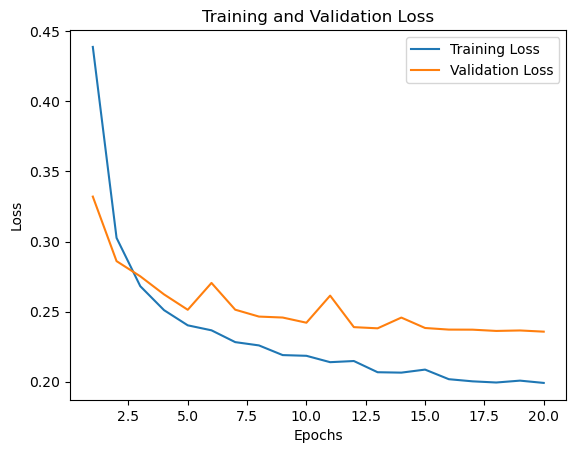

In [41]:
import matplotlib.pyplot as plt

# Assuming the training loop has already populated
# train_losses, train_accuracy, val_losses, val_accuracy

epochs = range(1, 21)  # 50 epochs, adjust if your epoch range is different

# Plotting training and validation loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

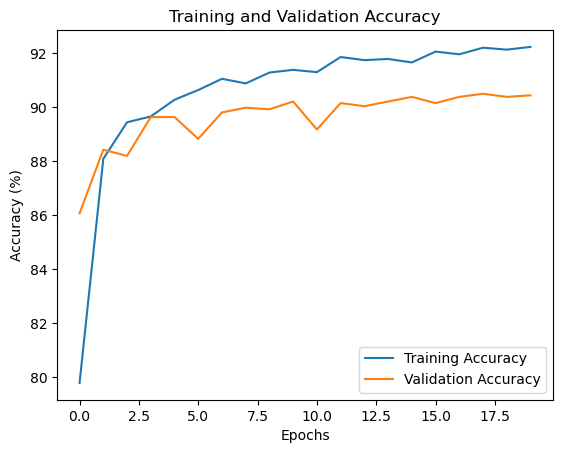

In [42]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#testing the model
test_loss, test_accuracy = fit(1, fc, tst_feat_loader, optimizer, phase='validation')

#predicting the output
preds = []
for data, target in tst_feat_loader:
  output = fc(data)
  preds.extend(output.data.max(1, keepdim=True)[1])

preds = torch.tensor(preds).flatten()
test_labels = np.array(test_labels)

#creating the confusion matrix
cf = confusion_matrix(test_labels, preds)
trn_labels = np.array(trn_labels)
val_labels = np.array(val_labels)

print(cf)

validation loss is  0.26 and validation accuracy is 1936/2172     89.13
[[954 129]
 [107 982]]


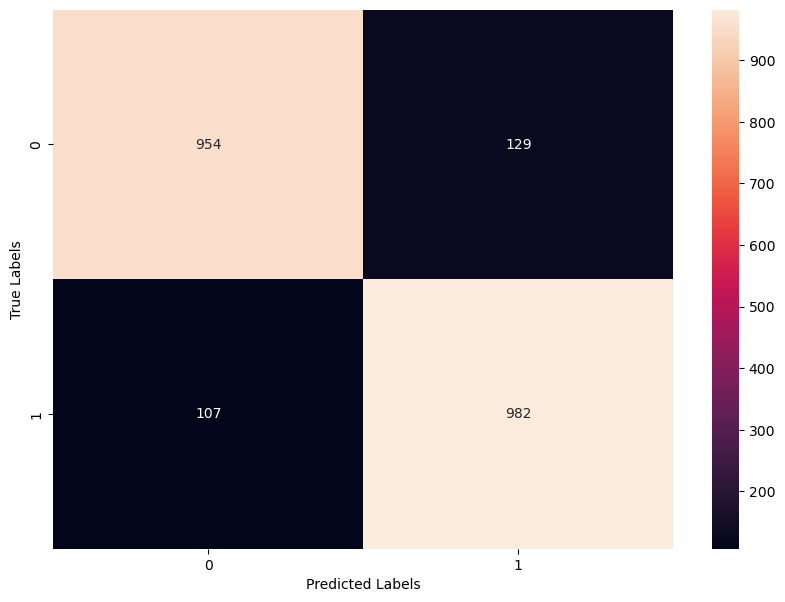

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cf, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
my_vgg = vgg16(pretrained=True)

if is_cuda:
    my_vgg = my_vgg.cuda()

In [49]:
m = nn.Sequential(*list(my_vgg.children())[:-1])

In [ ]:
#for training data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trn_labels = [] #stores the labels or the train data

trn_features = [] #stores the pre convoluted features of the train data

#iterate through the train data and store the calculated features and the labels
for d, la in train_loader:
  o = m(Variable(d.to(device)))  #a PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph
  o = o.view(o.size(0), -1)
  trn_labels.extend(la)
  trn_features.extend(o.to(device).data)

#for validation data

#iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d, la in val_loader:
  o = m(Variable(d.to(device)))
  o = o.view(o.size(0), -1)
  val_labels.extend(la)
  val_features.extend(o.to(device).data)

#for test data
test_labels = []
test_features = []
for d, la in test_data_loader:
  o = m(Variable(d.to(device)))
  o = o.view(o.size(0), -1)
  test_labels.extend(la)
  test_features.extend(o.to(device).data)

In [ ]:
#creating the dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features, trn_labels)
val_feat_dset = FeaturesDataset(val_features, val_labels)
tst_feat_dset = FeaturesDataset(test_features, test_labels)

#creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset, batch_size=64, shuffle=True)
val_feat_loader = DataLoader(val_feat_dset, batch_size=64)
tst_feat_loader = DataLoader(tst_feat_dset, batch_size=64)

In [ ]:
class FullyConnectedModel(nn.Module):
  def __init__(self, in_size, out_size):
    super().__init__()
    self.fc = nn.Linear(in_size, out_size)

  def forward(self, inp):
    out = self.fc(inp)
    return out

In [ ]:
fc_in_size = 512
classes = 2
fc = FullyConnectedModel(fc_in_size, classes)
if is_cuda:
  fc = fc.cuda()

In [ ]:
optimizer = optim.Adam(fc.parameters(), lr=0.001)

In [ ]:
fc = FullyConnectedModel(fc_in_size, classes)
if is_cuda:
  fc = fc.cuda()
  
optimizer = optim.Adam(fc.parameters(), lr=0.001)

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1, 21):
  running_loss, running_accuracy = fit(epoch, fc, trn_feat_loader, optimizer, phase='training')
  val_running_loss, val_running_accuracy = fit(epoch, fc, val_feat_loader, optimizer, phase='validation')
  train_losses.append(running_loss)
  train_accuracy.append(running_accuracy)
  val_losses.append(val_running_loss)
  val_accuracy.append(val_running_accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Assuming the training loop has already populated
# train_losses, train_accuracy, val_losses, val_accuracy

epochs = range(1, 21)  # 50 epochs, adjust if your epoch range is different

# Plotting training and validation loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#testing the model
test_loss, test_accuracy = fit(1, fc, tst_feat_loader, optimizer, phase='validation')

#predicting the output
preds = []
for data, target in tst_feat_loader:
  output = fc(data)
  preds.extend(output.data.max(1, keepdim=True)[1])

preds = torch.tensor(preds).flatten()
test_labels = np.array(test_labels)

#creating the confusion matrix
cf = confusion_matrix(test_labels, preds)
trn_labels = np.array(trn_labels)
val_labels = np.array(val_labels)

print(cf)